# Boston Marathon project

There is a lot of information on ​runners and their performance for the Boston Marathon​. Pick a year (post-2012 has more info) and do some clustering. Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. 

Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish. You must include analysis as: 

1. Draw bar graphs (both male & female in different color) for each cluster for male and female, from the bar graphs, you can tell things as which cluster contains the most number of female (or male).

2. Draw bar graphs for runners in different ranges of age (dividing by 3 groups: 18-25, 26-40, 40-70 or so) for each cluster (in different colors), from the graph, you should be able to anwser which cluster contains the most young people, which cluster contains oldest people, etc. 

3. Do the same things as above for finishing time (which group runs fastest). .


## 1. Data Exploration
## 2. Data pre-processing
## 3. Apply model
## 4. Analyse the clusters

## 1. Data Exploration
### 1.1 Importing Various Modules

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # for plotting graphs
%matplotlib inline
import numpy as np
import sklearn
import time
# Import model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score

### 1.2 Reading the data from a CSV file

In [4]:
pd.set_option('display.max_columns', None)
data = pd.read_csv("results.csv")
data.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


    **Bib Assigned race number based on qualifying time. "F" could appear for female elites.

    **NameName of runner (Last, First)

    **AgeAge on race day

    **M/FRunner's gender

    **5KRunner's time at 5k

    **10KRunner's time at 10k

    **15KRunner's time at 15k

    **20KRunner's time at 20k

    **HalfRunner's time at halfway point

    **25KRunner's time at 25k

    **30KRunner's time at 30k

    **35KRunner's time at 35k

    **40KRunner's time at 40k

    **PaceRunner's overall minute per mile pace

    **Proj TimeRunner's projected time during the race (empty)

    **Official TimeRunner's official finishing time

    **OverallRunner's overall raking

    **GenderRunner's ranking in their gender

    **DivisionRunner's ranking in their age division

In [5]:
data.shape

(31984, 21)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [7]:
# Convert these columns to numeric
numeric = ['10k','25k','age','official','35k','overall','pace','30k','5k','half','20k','40k']
data[numeric] = data[numeric].apply(pd.to_numeric, errors = 'coerce', axis=1)
print(data.dtypes)

10k          float64
name          object
division       int64
25k          float64
gender        object
age          float64
official     float64
bib           object
genderdiv      int64
ctz           object
35k          float64
overall      float64
pace         float64
state         object
30k          float64
5k           float64
half         float64
20k          float64
country       object
city          object
40k          float64
dtype: object


### 1.3 Check missing values

In [8]:
# Percentage of missing values
data.isnull().sum()/len(data)*100

10k           0.156328
name          0.000000
division      0.000000
25k           0.675338
gender        0.000000
age           0.000000
official      0.000000
bib           0.000000
genderdiv     0.000000
ctz          96.110555
35k           0.106303
overall       0.000000
pace          0.000000
state         8.054027
30k           0.125063
5k            0.162581
half          0.225113
20k           0.159455
country       0.000000
city          0.003127
40k           0.121936
dtype: float64

**ctz  missing value  are over 90%  -> drop this column
** The other missing value is around 1% -> small amount -> removed these row data

In [9]:
data = data.drop(['ctz'], axis=1)
data = data.dropna()

## 2. Data pre-processing

In [10]:
data.select_dtypes(['object']).columns

Index(['name', 'gender', 'bib', 'state', 'country', 'city'], dtype='object')

### country , city  & state         

In [11]:
data['country'].unique()

array(['USA', 'CAN'], dtype=object)

In [12]:
data['country'].value_counts()

USA    26939
CAN     2164
Name: country, dtype: int64

> After  remove ctz , we just have USA & CAN and most of them is USA. Since the people of  USA and CAN are look like together physically  -> this feature this feature is not have much value for the model , i will remove it

In [13]:
data['city'].value_counts()

Boston           1018
New York          497
Chicago           312
Cambridge         303
Somerville        239
                 ... 
Medford Lakes       1
Sleepy Eye          1
Toccoa              1
Tahoma              1
Hubley              1
Name: city, Length: 4648, dtype: int64

> We have more than 4668 cities -> too many for oneHotEncoding -> remove this columns as well

In [14]:
data['state'].value_counts()

MA    7427
CA    2302
NY    1537
ON    1045
PA     997
      ... 
YT       5
NT       3
GU       1
AA       1
AP       1
Name: state, Length: 68, dtype: int64

> the state is the same cities, this value doesn't  effect to the marathon result

In [15]:
data = data.drop(['city','country','state'], axis=1)

### name    
> Seems it is the unique for each row and there is no meaning for calculating, so that i will remove this columns 

In [16]:
data = data.drop(['name'], axis=1)

### bib    

In [17]:
data['bib'].unique()

array(['6', 'W8', 'F8', ..., '35910', '35911', '35912'], dtype=object)

> I dont know what it is , and this column is mixed between String and number -> I will remove it

In [18]:
data = data.drop(['bib'], axis=1)

### gender

Gender should be a key factor for the marathon result 


In [19]:
data['gender'].value_counts()

M    15578
F    13525
Name: gender, dtype: int64

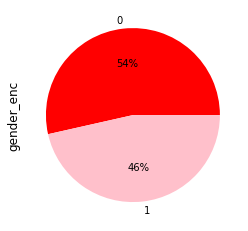

In [71]:
data['gender'].value_counts().plot.pie( autopct='%1.0f%%',
                                shadow=False, startangle=0, colors  = ['red', 'pink'])

There are 15691 Men and 13717 Female. The inequality of male and female is not really high

I will use LabelEncoding for this column

In [20]:
data['gender_enc'] = data['gender']
data['gender_enc'] = data['gender_enc'].str.replace('M','0')
data['gender_enc'] = data['gender_enc'].str.replace('F','1')
data['gender_enc'] = pd.to_numeric(data['gender_enc'], errors='coerce')

In [72]:
# data['gender_enc'].value_counts()

In [22]:
data = data.drop(['gender'], axis=1)

### numeric

In [23]:
data.select_dtypes(['int64', 'float64']).columns

Index(['10k', 'division', '25k', 'age', 'official', 'genderdiv', '35k',
       'overall', 'pace', '30k', '5k', 'half', '20k', '40k', 'gender_enc'],
      dtype='object')

In [24]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
10k,29103.0,51.827082,8.704309,17.12,45.580,50.43,57.200,112.38
division,29103.0,1966.941037,1732.202728,1.00,623.500,1445.00,2703.500,6979.00
25k,29103.0,134.107068,25.627832,48.55,115.920,129.23,148.430,289.02
age,29103.0,42.054256,11.348288,18.00,33.000,42.00,50.000,81.00
official,29103.0,242.813434,50.921669,84.82,205.980,232.57,273.310,538.88
genderdiv,29103.0,8008.425935,4733.455790,1.00,3954.500,7923.00,11908.500,17575.00
35k,29103.0,196.771704,40.869530,70.83,167.550,188.40,220.270,449.33
overall,29103.0,15980.928942,9169.893647,1.00,8074.500,15997.00,23946.000,31931.00
pace,29103.0,9.269305,1.942165,3.25,7.870,8.88,10.430,20.57
30k,29103.0,164.525433,32.965134,59.77,141.075,157.98,183.125,376.38


### Finishers by age

Text(0.5, 1.0, 'Participants per age group')

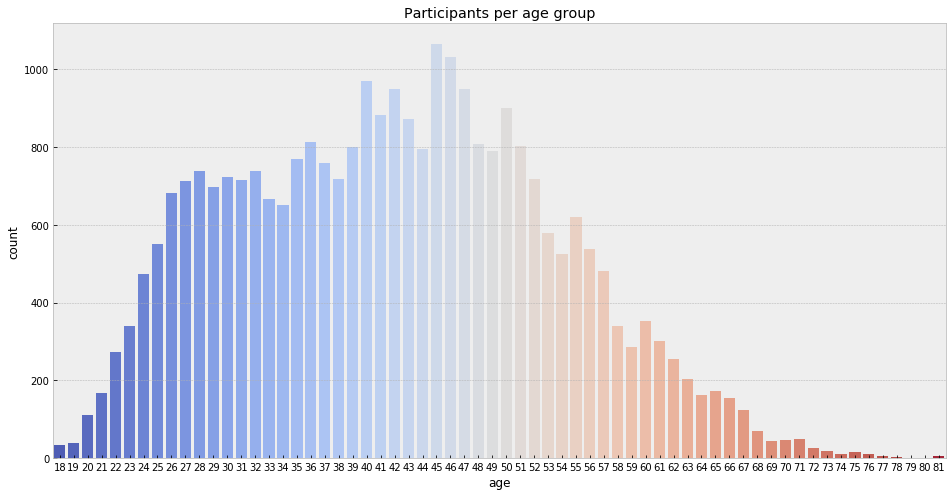

In [65]:
data.age = data.age.astype(int)
g = sns.countplot('age', data=data, palette="coolwarm")
g.figure.set_size_inches(16,8)
g.set_title("Participants per age group")

> this constent attracted many  midle-age people from 40 - 50 

### Finishers by age  & gender


Text(0.5, 1.0, 'Participants per Age & Gender')

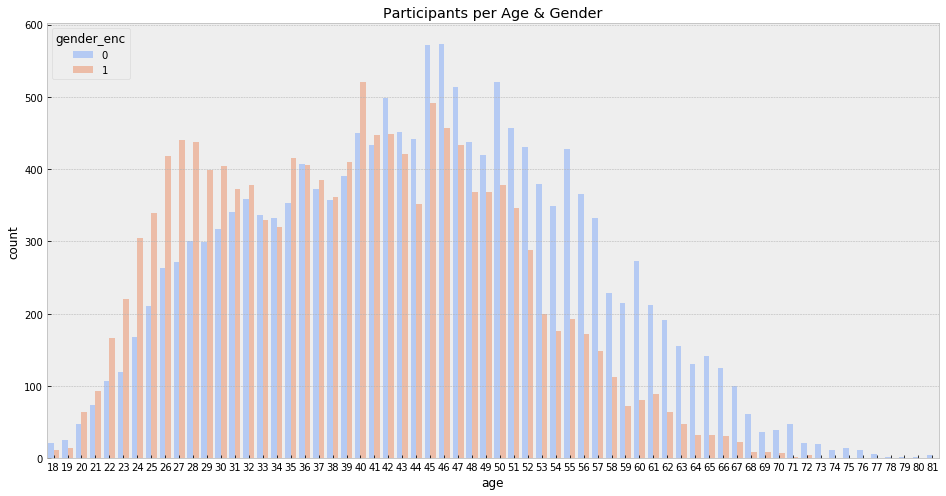

In [64]:
g = sns.countplot('age', data=data, palette="coolwarm", hue='gender_enc')
g.figure.set_size_inches(16,8)
g.set_title("Participants per Age & Gender")

> so suprised  that  female dominate the number of finisher in young group from 20 - 32
> When the men get older they are tougher

### Finishers by age  & official

Text(0.5, 1.0, 'Distribution of finish times per Age group')

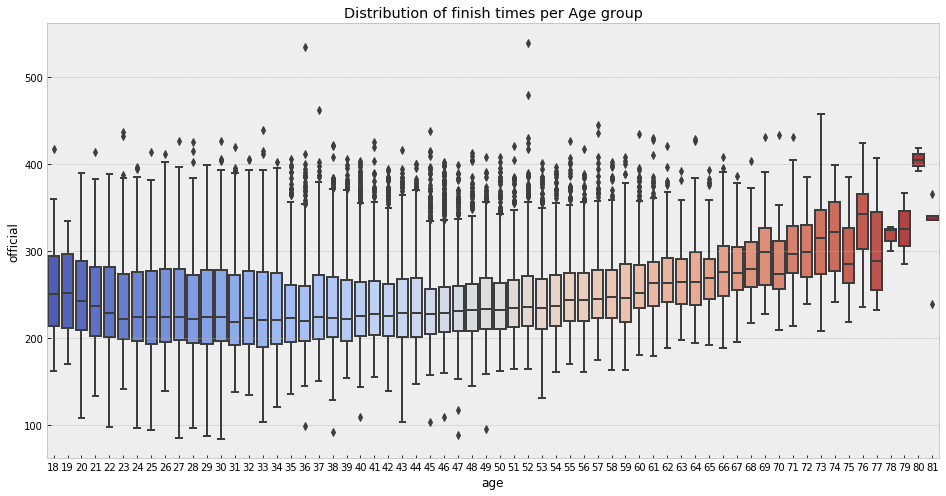

In [77]:
g = sns.boxplot(x='age', y='official', data=data, palette="coolwarm")
g.figure.set_size_inches(16,8)
g.set_title("Distribution of finish times per Age group")

## 3. Apply model
## 3.1 Apply model without PCA


In [171]:
# X = StandardScaler().fit_transform(data)
# X = data
# X

In [172]:
X_scaled = StandardScaler().fit_transform(data)
X_scaled = pd.DataFrame(X_scaled, columns = data.columns)

In [173]:
def investigate_silhouette_score(X,start_i, end_i):
    range_n_clusters = range(start_i, end_i)
    for n_clusters in range_n_clusters:
        clusterer = KMeans (n_clusters=n_clusters)
        preds = clusterer.fit_predict(X)
        centers = clusterer.cluster_centers_
        score = silhouette_score (X, preds, metric='euclidean')
        print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

In [174]:
def investigate_ellbow(X,start_i, end_i):
    range_n_clusters = range(start_i, end_i)
    inertias = []
    for k in range_n_clusters:
        model = KMeans(n_clusters=k)
        k_m = model.fit(X_scaled)
        inertias.append(model.inertia_)
    #     y_clust = k_m.predict(X_scaled)
    #     score = silhouette_score (X_scaled, y_clust, metric='euclidean')
    #     print ("For n_clusters = {}, silhouette score is {})".format(k, score))

    plt.figure(figsize=(8,5))
    plt.style.use('bmh')
    plt.plot(range_n_clusters, inertias, '-o')
    plt.xlabel('Number of clusters, k')
    plt.ylabel('Inertia')
    plt.xticks(range_n_clusters)
    plt.show()

In [175]:
investigate_silhouette_score(X_scaled,2,8)

For n_clusters = 2, silhouette score is 0.4494824812771044)
For n_clusters = 3, silhouette score is 0.3340327041035656)
For n_clusters = 4, silhouette score is 0.27987219395669233)
For n_clusters = 5, silhouette score is 0.3060316915117092)
For n_clusters = 6, silhouette score is 0.317224671169796)
For n_clusters = 7, silhouette score is 0.30583763954478504)


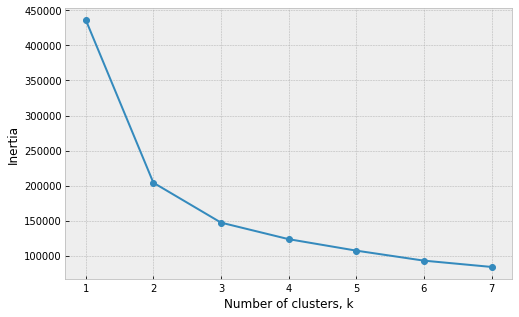

In [177]:
investigate_ellbow(X_scaled,1,8)

> Looks like the best value ("elbow" of the line) for k is 3 (three clusters).

In [179]:
best_cluster_num =2;
# best_cluster = KMeans(n_clusters=best_cluster_num)
# best_cluster_model = best_cluster.fit(X)
# print("model\n", best_cluster_model)

In [116]:
# y_clust = best_cluster_model.predict(X)
# silhouette_score(X, y_clust, metric='euclidean')

In [78]:
# centers = best_cluster_model.cluster_centers_
# centers

In [29]:
# Function that creates a DataFrame with a column for Cluster Number

# def pd_centers(featuresUsed, centers):
#     colNames = list(featuresUsed)
#     colNames.append('prediction')

#     # Zip with a column called 'prediction' (index)
#     Z = [np.append(A, index) for index, A in enumerate(centers)]

#     # Convert to pandas data frame for plotting
#     P = pd.DataFrame(Z, columns=colNames)
#     P['prediction'] = P['prediction'].astype(int)
#     return P

In [79]:
P = pd_centers(data.select_dtypes(['int64', 'float64']).columns, centers)
P

#### Data exploration each cluster

In [238]:
# no print describle table
def investigate_kmeans(X,origin_data, best_cluster_num):
    best_cluster_pred = KMeans(n_clusters=best_cluster_num, random_state=42).fit_predict(X)
    X_pred = origin_data.copy()
    X_pred['cluster_assignment'] = best_cluster_pred
    return X_pred

In [180]:

def investigate_kmeans_2(X,origin_data, best_cluster_num):
    best_cluster_pred = KMeans(n_clusters=best_cluster_num, random_state=42).fit_predict(X)
    X_pred = origin_data.copy()
    X_pred['cluster_assignment'] = best_cluster_pred
    #     X_pred = X.copy()
    #     X_pred['cluster_assignment'] = best_cluster_pred

    cluster_dataframes = {}
    for n_clust in range(best_cluster_num):
        cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]

    for name, frame in cluster_dataframes.items():
        print(f"THIS IS CLUSTER {name+1}")
        print(frame.describe().transpose())
        print("+++++++++++============================================================================+++++")
    return X_pred

data_pred = investigate_kmeans_2(X_scaled,data, best_cluster_num)

THIS IS CLUSTER 1
                      count          mean          std    min      25%  \
10k                 18673.0     46.690596     4.779043  17.12    43.23   
division            18673.0   1353.554008  1119.492138   1.00   466.00   
25k                 18673.0    118.721547    12.429956  48.55   109.73   
age                 18673.0     41.305843    10.425780  18.00    33.00   
official            18673.0    211.755520    24.318578  84.82   194.72   
genderdiv           18673.0   5286.372302  3288.734260   1.00  2524.00   
35k                 18673.0    171.889208    18.967373  70.83   158.40   
overall             18673.0  10344.985755  5999.462709   1.00  5214.00   
pace                18673.0      8.084726     0.927582   3.25     7.43   
30k                 18673.0    144.588139    15.479786  59.77   133.48   
5k                  18673.0     23.323613     2.400359   8.02    21.65   
half                18673.0     99.493725    10.268835  40.20    91.98   
20k                 

### Apply model with PCA

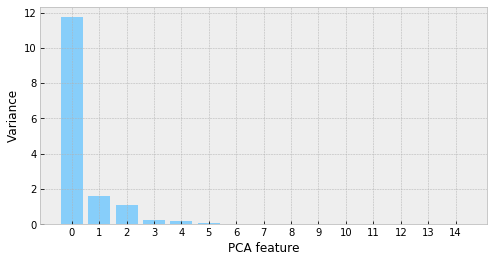

In [181]:
#check for optimal number of features
pca = PCA(random_state=123)
pca.fit(X_scaled)
features = range(pca.n_components_)

plt.figure(figsize=(8,4))
plt.bar(features[:15], pca.explained_variance_[:15], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features[:15])
plt.show()

> 2 feature seems to be best fit for our algorithm.

In [183]:
pca = PCA(n_components=2, random_state=123)
data_pca = pca.fit_transform(X_scaled)
print('Shape of the new Data pca: ' + str(data_pca.shape))

Shape of the new Data pca: (29103, 2)


In [184]:
investigate_silhouette_score(data_pca,2,8)

For n_clusters = 2, silhouette score is 0.5082208859003402)
For n_clusters = 3, silhouette score is 0.40767032189962177)
For n_clusters = 4, silhouette score is 0.35461215199807444)
For n_clusters = 5, silhouette score is 0.354403049161937)
For n_clusters = 6, silhouette score is 0.36454144085349843)
For n_clusters = 7, silhouette score is 0.37491365455672854)


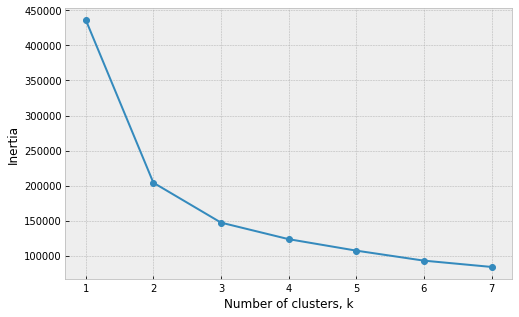

In [185]:
investigate_ellbow(data_pca,1,8)

> the silhouette score is better and the best K  is still 2

In [ ]:
best_cluster_num = 2

In [188]:
data_pca = pd.DataFrame(data_pca, columns = ['label1','label2'])

In [189]:
data_pred_pca = investigate_kmeans_2(data_pca,data_pca, best_cluster_num)

THIS IS CLUSTER 1
                      count      mean       std       min       25%       50%  \
label1              10533.0  3.750236  2.223815  0.806073  1.906100  3.317382   
label2              10533.0  0.001353  1.544518 -2.963160 -1.435212  0.110840   
cluster_assignment  10533.0  0.000000  0.000000  0.000000  0.000000  0.000000   

                         75%        max  
label1              5.135069  17.876516  
label2              1.147536   4.089331  
cluster_assignment  0.000000   0.000000  
+++++++++++============================================================================+++++
THIS IS CLUSTER 2
                      count      mean       std        min       25%      50%  \
label1              18570.0 -2.127153  1.755455 -10.947860 -3.396483 -1.97787   
label2              18570.0 -0.000768  1.086785  -2.572132 -0.879646  0.01849   
cluster_assignment  18570.0  1.000000  0.000000   1.000000  1.000000  1.00000   

                         75%       max  
label1      

In [191]:
data_pred_pca

,label1,label2,cluster_assignment
0,-7.548304,-0.305843,1
1,-10.930923,-0.513932,1
2,-6.693082,-1.086615,1
3,-10.654799,0.661572,1
4,-10.676744,-0.444639,1
...,...,...,...
29098,-1.320283,-0.835273,1
29099,4.341840,-0.762698,0
29100,3.051492,-2.568197,0
29101,4.564534,-1.549821,0


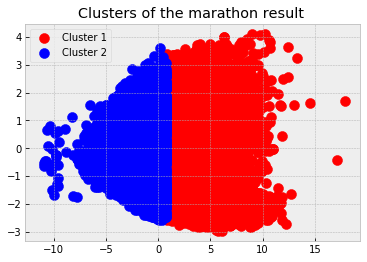

In [194]:
#Visualizing all the clusters 

plt.scatter(data_pred_pca.label1[data_pred_pca['cluster_assignment'] == 0], data_pred_pca.label2[data_pred_pca['cluster_assignment'] == 0], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(data_pred_pca.label1[data_pred_pca['cluster_assignment'] == 1], data_pred_pca.label2[data_pred_pca['cluster_assignment'] == 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.title('Clusters of the marathon result ')
plt.legend()
plt.show()

In [245]:
# data_pred_pca_t = investigate_kmeans(data_pca,data_pca, 6)
# #Visualizing all the clusters 

# plt.scatter(data_pred_pca_t.label1[data_pred_pca['cluster_assignment'] == 0], data_pred_pca_t.label2[data_pred_pca['cluster_assignment'] == 0], s = 100, c = 'red', label = 'Cluster 1')
# plt.scatter(data_pred_pca_t.label1[data_pred_pca['cluster_assignment'] == 1], data_pred_pca_t.label2[data_pred_pca['cluster_assignment'] == 1], s = 100, c = 'blue', label = 'Cluster 2')
# plt.title('Clusters of the marathon result ')
# plt.legend()
# plt.show()

## 4. Analyse the clusters


In [195]:
data_pred = investigate_kmeans_2(data_pca,data, best_cluster_num)

THIS IS CLUSTER 1
                      count          mean          std       min       25%  \
10k                 10533.0     60.962535     6.224193     41.78     56.35   
division            10533.0   3046.506219  2062.242029      1.00   1402.00   
25k                 10533.0    161.446374    19.342958    117.78    146.05   
age                 10533.0     43.449919    12.710763     18.00     33.00   
official            10533.0    297.947220    36.976801    233.07    268.43   
genderdiv           10533.0  12836.131017  2509.975344   5791.00  10958.00   
35k                 10533.0    240.954960    30.465571    183.35    216.42   
overall             10533.0  26012.418589  3429.083250  16108.00  23224.00   
pace                10533.0     11.372170     1.410122      8.90     10.25   
30k                 10533.0    199.939371    24.888358    140.52    179.98   
5k                  10533.0     30.148027     2.991246     17.90     28.03   
half                10533.0    133.229971    1

In [196]:

def get_cluster_by_assignment(X, cluster_assignment_num ):
        
        return  X.loc[X['cluster_assignment'] == cluster_assignment_num]

     

In [197]:
k_cluster1 = get_cluster_by_assignment( data_pred, 0 )
k_cluster2 = get_cluster_by_assignment( data_pred, 1 )
# k_cluster3 = get_cluster_by_assignment( data_pred, 2 )
# k_cluster4 = get_cluster_by_assignment( data_pred, 3 )

In [34]:
# k_cluster1['gender_enc'].value_counts()

In [35]:
# f, plotgrid = plt.subplots(2, 2,figsize=(15,8))
# sns.countplot(data=k_cluster1, x = 'gender_enc', ax = plotgrid[0,0])
# sns.countplot(data=k_cluster2, x = 'gender_enc', ax = plotgrid[0,1])
# sns.countplot(data=k_cluster3, x = 'gender_enc', ax = plotgrid[1,0])
# sns.countplot(data=k_cluster4, x = 'gender_enc', ax = plotgrid[1,1])

In [199]:
# f, plotgrid = plt.subplots(2, 2,figsize=(15,10))
# for i in range(4):
#     rows = int(np.floor(i / 2))
#                 # 0,0,1,1
#     cols = i % 2
#                 # 0,1,0,1
#     x_data = get_cluster_by_assignment( data_pred, i  )    
#     sns.countplot(data= x_data, x = 'gender_enc', ax = plotgrid[rows,cols]) 
#     plotgrid[rows, cols].set_xlabel(f'Male & Female -  {x_data.gender_enc.count()} ')
#     plotgrid[rows, cols].set_ylabel('Number of Occurrences')
#     plotgrid[rows, cols].set_title(f'Cluster {i}')

### 4.1 1. Draw bar graphs (both male & female in different color) for each cluster for male and female, from the bar graphs, you can tell things as which cluster contains the most number of female (or male).

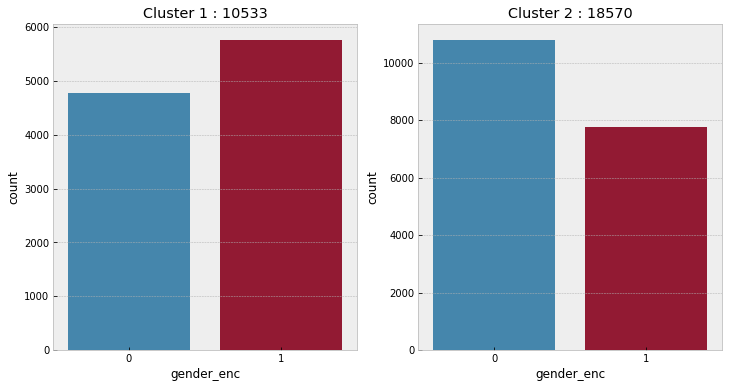

In [205]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
sns.countplot(data=k_cluster1, x = 'gender_enc', ax = ax1) 
ax1.set_title(f'Cluster {1} : {k_cluster1.AgeGroup.count()}')
sns.countplot(data=k_cluster2, x = 'gender_enc', ax = ax2) 
ax2.set_title(f'Cluster {2} : {k_cluster2.AgeGroup.count()}')
plt.show()

> the amount of people in cluster 1 is fewer than cluster 2
> the amount of female in cluster 1 is greater than cluster 2
> the mean pace of cluster 1 (12) > cluster 2 (7) -> it quite looks like the distribution graph by age in data exploration content 


### 4.2 Draw bar graphs for runners in different ranges of age (dividing by 3 groups: 18-25, 26-40, 40-70 or so)

In [209]:
bins= [18,26,41,71,90]
labels = ['18-25','26-40','41-70','71-90']
k_cluster1['AgeGroup'] = pd.cut(k_cluster1['age'], bins=bins, labels=labels, right=False)
k_cluster2['AgeGroup'] = pd.cut(k_cluster2['age'], bins=bins, labels=labels, right=False)
# k_cluster3['AgeGroup'] = pd.cut(k_cluster3['age'], bins=bins, labels=labels, right=False)
# k_cluster4['AgeGroup'] = pd.cut(k_cluster4['age'], bins=bins, labels=labels, right=False)

c:\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [201]:
k_cluster1.AgeGroup.count()

10533

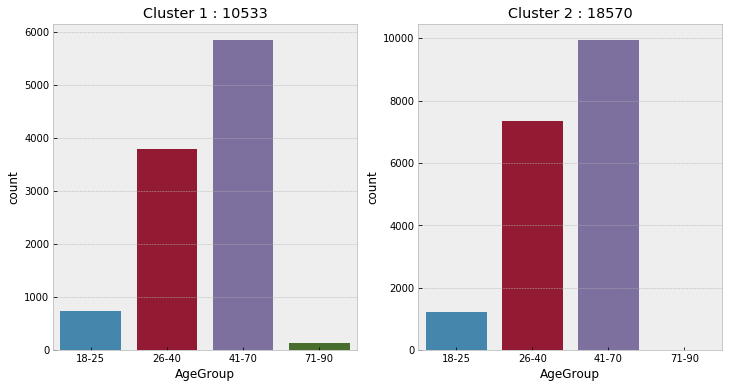

In [206]:

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))

sns.countplot(data=k_cluster1, x = 'AgeGroup', ax = ax1) 
ax1.set_title(f'Cluster {1} : {k_cluster1.AgeGroup.count()}')
sns.countplot(data=k_cluster2, x = 'AgeGroup', ax = ax2) 
ax2.set_title(f'Cluster {2} : {k_cluster2.AgeGroup.count()}')
# sns.countplot(data=k_cluster3, x = 'AgeGroup', ax = plotgrid[1,0]) 
# plotgrid[1,0].set_title(f'Cluster {3} : {k_cluster3.AgeGroup.count()}')
# sns.countplot(data=k_cluster4, x = 'AgeGroup', ax = plotgrid[1,1]) 
# plotgrid[1,1].set_title(f'Cluster {4} : {k_cluster4.AgeGroup.count()}')
plt.show()

> age group doesn't tell us much about the cluster

### 4.3  Draw bar graphs for runners for finishing time  (which group runs fastest)
#### 4.3.1  Finished Time

Text(0.5, 1.0, 'Cluster 2 : 18570')

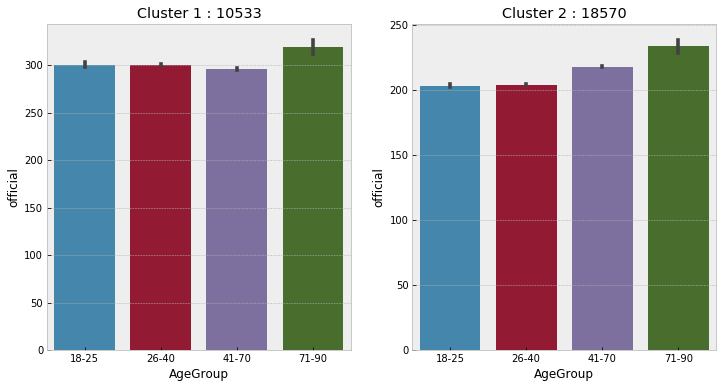

In [208]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))

sns.barplot(data=k_cluster1, x = 'AgeGroup', y ='official', ax = ax1) 
ax1.set_title(f'Cluster {1} : {k_cluster1.AgeGroup.count()}')
sns.barplot(data=k_cluster2, x = 'AgeGroup',  y ='official',ax = ax2) 
ax2.set_title(f'Cluster {2} : {k_cluster2.AgeGroup.count()}')

>  offical mean of cluster 1 : 321.12 
>  offical mean of cluster 2 : 211

## 5. Cluster for only Male group

In [227]:
male_data = data.loc[data['gender_enc'] == 0]

In [228]:
male_data_scaled = StandardScaler().fit_transform(male_data)
male_data_scaled = pd.DataFrame(male_data_scaled, columns = male_data.columns)

In [229]:
pca = PCA(n_components=2, random_state=123)
male_data_pca = pca.fit_transform(male_data_scaled)
print('Shape of the new Data pca: ' + str(male_data_pca.shape))

Shape of the new Data pca: (15578, 2)


In [268]:
investigate_silhouette_score(male_data_pca,2,10)

For n_clusters = 2, silhouette score is 0.542185215338008)
For n_clusters = 3, silhouette score is 0.43332238728814226)
For n_clusters = 4, silhouette score is 0.37834506894177616)
For n_clusters = 5, silhouette score is 0.3752979718526662)
For n_clusters = 6, silhouette score is 0.3601140061035094)
For n_clusters = 7, silhouette score is 0.38706584111760517)
For n_clusters = 8, silhouette score is 0.38536864487865)
For n_clusters = 9, silhouette score is 0.38896540658225104)


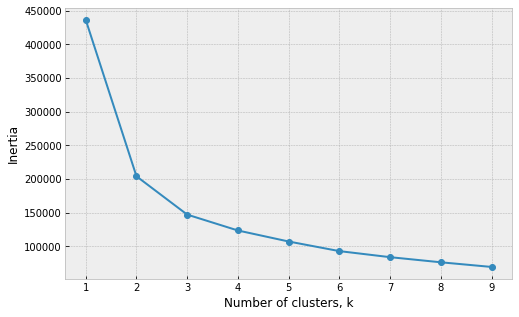

In [269]:
investigate_ellbow(male_data_pca,1,10)

> 2 cluster seems to be the best one

In [232]:
male_data_pred = investigate_kmeans_2(male_data_pca,male_data, 2)

THIS IS CLUSTER 1
                     count          mean          std       min         25%  \
10k                 5476.0     59.410049     6.239572     41.78     54.9700   
division            5476.0   2674.400840  1749.578385      1.00   1325.7500   
25k                 5476.0    156.507810    19.475521    112.23    141.3300   
age                 5476.0     46.896640    13.114706     18.00     37.0000   
official            5476.0    292.249005    38.540351    224.00    261.9775   
genderdiv           5476.0  14441.442659  1841.560111   9263.00  12958.7500   
35k                 5476.0    234.866326    31.439501    184.43    209.6775   
overall             5476.0  25268.176771  3917.786465  13615.00  22164.7500   
pace                5476.0     11.154717     1.469662      8.55     10.0000   
30k                 5476.0    194.202184    25.373634    143.70    174.1300   
5k                  5476.0     29.474397     3.064364     17.90     27.3775   
half                5476.0    129.

In [234]:
male_data_pca2 = pd.DataFrame(male_data_pca, columns = ['label1','label2'])
male_data_pca2.isnull().sum()

label1    0
label2    0
dtype: int64

In [266]:
#Visualizing all the clusters 
# male_data_pred_pca = investigate_kmeans(male_data_pca2,male_data_pca2, 2)
# plt.scatter(male_data_pred_pca.label1[male_data_pred_pca['cluster_assignment'] == 0], male_data_pred_pca.label2[male_data_pred_pca['cluster_assignment'] == 0], s = 100 , c = 'red', label = 'Cluster 1')
# plt.scatter(male_data_pred_pca.label1[male_data_pred_pca['cluster_assignment'] == 1], male_data_pred_pca.label2[male_data_pred_pca['cluster_assignment'] == 1], s = 100, c = 'blue', label = 'Cluster 2')
# plt.scatter(male_data_pred_pca.label1[male_data_pred_pca['cluster_assignment'] == 2], male_data_pred_pca.label2[male_data_pred_pca['cluster_assignment'] == 2], s = 100, c = 'pink', label = 'Cluster 3')
# plt.scatter(male_data_pred_pca.label1[male_data_pred_pca['cluster_assignment'] == 3], male_data_pred_pca.label2[male_data_pred_pca['cluster_assignment'] == 3], s = 100, c = 'yellow', label = 'Cluster 4')

# plt.title('Clusters of the marathon result ')
# plt.legend()
# plt.show()

i là : 2


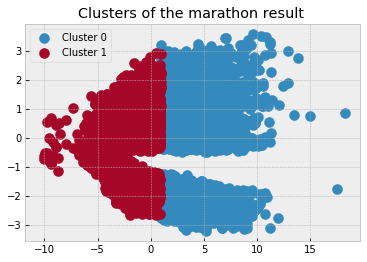

i là : 3


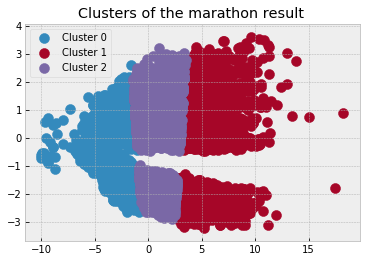

i là : 4


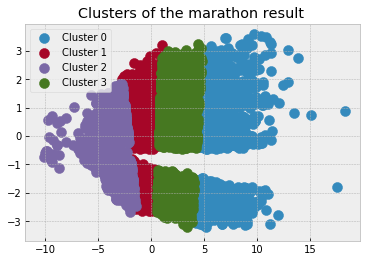

i là : 5


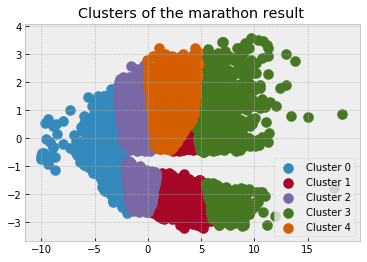

i là : 6


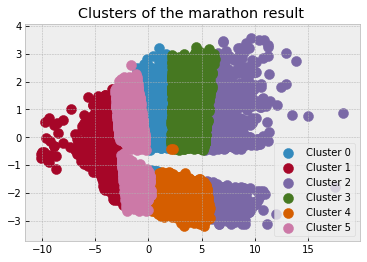

i là : 7


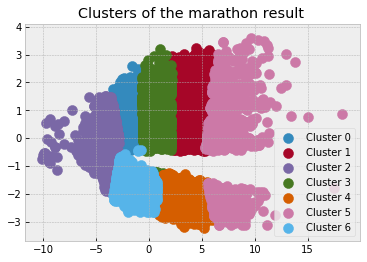

i là : 8


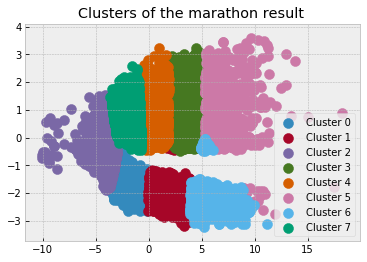

i là : 9


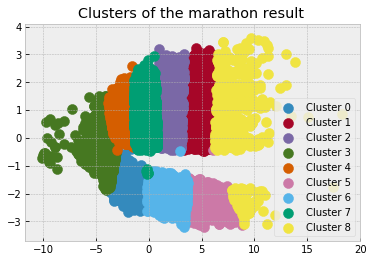

In [267]:
for i in range(2,10):
    print(f"i là : {i}")
    male_data_pred_pca = investigate_kmeans(male_data_pca2,male_data_pca2, i)
    for j in range(0,i):
        plt.scatter(male_data_pred_pca.label1[male_data_pred_pca['cluster_assignment'] == j ], male_data_pred_pca.label2[male_data_pred_pca['cluster_assignment'] == j], s = 100, label = 'Cluster '+str(j) )
    plt.title('Clusters of the marathon result ')
    plt.legend()
    plt.show()

The male group looks best with 2 clusters -- this gives a mean silhouette score of 0.54. The overall ranking varies by about 25268-7733 per group. THe highest ranking group has an average age of 46 and the other is 57 -> this might group the data by the age. the younger is alway better than the older , the mean pace is 12  and 7 repectively

## 6. Cluster for only Female group

In [270]:
female_data = data.loc[data['gender_enc'] == 1]

In [271]:
female_data_scaled = StandardScaler().fit_transform(female_data)
female_data_scaled = pd.DataFrame(female_data_scaled, columns = female_data.columns)

In [272]:
pca = PCA(n_components=2, random_state=123)
female_data_pca = pca.fit_transform(female_data_scaled)
print('Shape of the new Data pca: ' + str(female_data_pca.shape))

Shape of the new Data pca: (13525, 2)


In [273]:
investigate_silhouette_score(female_data_pca,2,10)

For n_clusters = 2, silhouette score is 0.5362295334018379)
For n_clusters = 3, silhouette score is 0.4244902898943523)
For n_clusters = 4, silhouette score is 0.3781235463301391)
For n_clusters = 5, silhouette score is 0.3854834822841182)
For n_clusters = 6, silhouette score is 0.4081667872860823)
For n_clusters = 7, silhouette score is 0.40777399251354457)
For n_clusters = 8, silhouette score is 0.4053558399155495)
For n_clusters = 9, silhouette score is 0.41046091162539716)


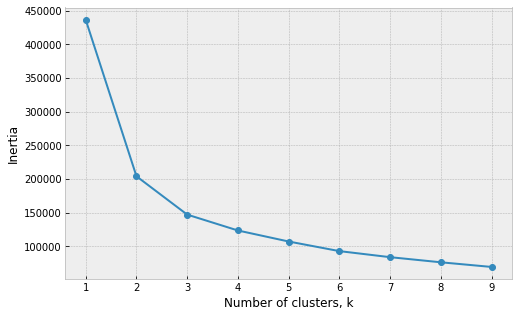

In [274]:
investigate_ellbow(female_data_pca,1,10)

> 2 cluster seems to be the best one

In [275]:
female_data_pred = investigate_kmeans_2(female_data_pca,female_data, 2)

THIS IS CLUSTER 1
                     count          mean          std    min        25%  \
10k                 9086.0     50.008245     3.961565  20.65    47.5000   
division            9086.0   1500.440568  1293.245371   1.00   468.0000   
25k                 9086.0    127.754057    10.414127  54.18   120.8725   
age                 9086.0     39.341624     9.712100  18.00    31.0000   
official            9086.0    227.029055    21.488948  95.10   211.9850   
genderdiv           9086.0   4810.308607  2806.436963   1.00  2384.2500   
35k                 9086.0    185.048164    16.427815  79.15   173.8000   
overall             9086.0  14060.395333  5453.214186  17.00  9928.2500   
pace                9086.0      8.667328     0.819763   3.63     8.1000   
30k                 9086.0    155.739354    13.161005  66.48   146.9050   
5k                  9086.0     24.945012     2.005426   9.65    23.6500   
half                9086.0    106.884591     8.511278  45.43   101.4200   
20k    

In [276]:
female_data_pca2 = pd.DataFrame(female_data_pca, columns = ['label1','label2'])
female_data_pca2.isnull().sum()

label1    0
label2    0
dtype: int64

i là : 2


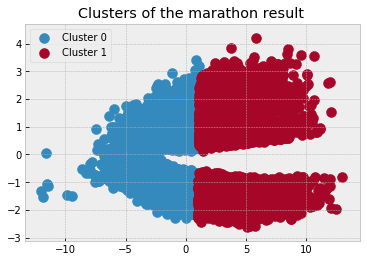

i là : 3


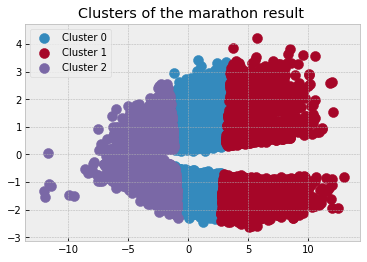

i là : 4


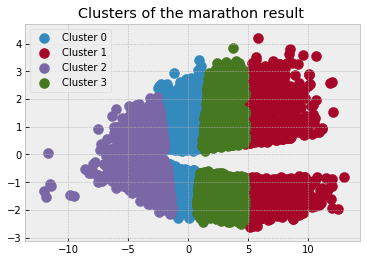

In [278]:
for i in range(2,5):
    female_data_pred_pca = investigate_kmeans(female_data_pca2,female_data_pca2, i)
    for j in range(0,i):
        plt.scatter(female_data_pred_pca.label1[female_data_pred_pca['cluster_assignment'] == j ], female_data_pred_pca.label2[female_data_pred_pca['cluster_assignment'] == j], s = 100, label = 'Cluster '+str(j) )
    plt.title('Clusters of the marathon result ')
    plt.legend()
    plt.show()

> For the female clusters,  2 clusters are still the best K. But the red color is greater than the blue one , so that the pace and ranking also better

> so I think this Dataset should be clustered into 4 clusters, 2 for male ( beginner - senior  ) , also the same for female groups ( 2 clusters : beginner - senior  ) 